# Imports

In [7]:
import os
import tifffile
import numpy as np
import pandas as pd
import tensorflow as tf
from seaborn import heatmap
from tensorflow import keras
import segmentation_models as sm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define generator
class MyGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, x_data='x_data/', y_data='y_data/', split=1.):
        self.batch_size = (64,)
        self.img_size = (64, 64)
        self.x_data = x_data
        self.y_data = y_data
        self.images = np.array(os.listdir(self.x_data))
        np.random.shuffle(self.images)

        # split > 0 => train split (0.8)
        # split < 0 => validation split (-0.2 means 20% of the data only) 
        np.random.seed(42)
        if split > 0.:
            self.images = self.images[:int(split * len(self.images))]
        else:
            self.images = self.images[int(split * len(self.images)):]

    def __len__(self):
        return len(self.images) // self.batch_size[0]

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""

        # get paths
        images = self.images[idx*self.batch_size[0]:(idx+1)*self.batch_size[0]]
        
        # create arrays
        x = np.zeros(self.batch_size + self.img_size + (2,), dtype='float32')
        y = np.zeros(self.batch_size + self.img_size + (5,), dtype='float32')

        # read data
        for i in range(self.batch_size[0]):
            x[i] = tifffile.imread(self.x_data + images[i])
            y_r = tifffile.imread(self.y_data + images[i])
            y_r.shape = self.img_size
            y[i, y_r == 0] = [1, 0, 0, 0, 0]
            y[i, y_r == 1] = [0, 1, 0, 0, 0]
            y[i, y_r == 2] = [0, 0, 1, 0, 0]
            y[i, y_r == 3] = [0, 0, 0, 1, 0]
            y[i, y_r == 4] = [0, 0, 0, 0, 1]

        return x, y

In [25]:
train_generator = MyGenerator('../scripts/data/data/x_data/', '../scripts/data/data/y_data/')
test_generator = MyGenerator('../scripts/data/data2/x_data/', '../scripts/data/data2/y_data/', split=0.8)
val_generator = MyGenerator('../scripts/data/data2/x_data/', '../scripts/data/data2/y_data/', split=-0.2)

(64, 64, 64, 2) float32 -0.072819546 0.637781
0.06381221 0.5225907


(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x29413478bc8>)

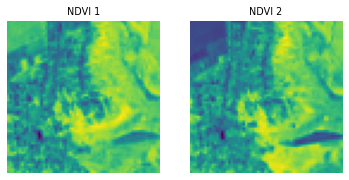

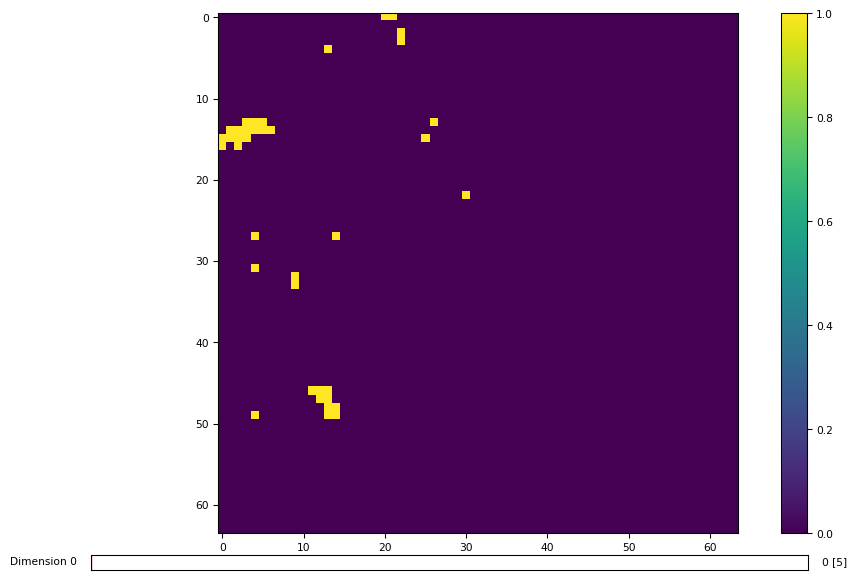

In [27]:
x, y = train_generator.__getitem__(0)
print(x.shape, x.dtype, x.min(), x.max())
print(x[15].min(), x[15].max())
plt.subplot(1, 2, 1)
plt.axis(False)
plt.title('NDVI 1')
plt.imshow(x[15, :, :, 0])
plt.subplot(1, 2, 2)
plt.axis(False)
plt.title('NDVI 2')
plt.imshow(x[15, :, :, 1])

tifffile.imshow(y[15])

In [12]:
model = sm.Unet('vgg16', input_shape=(None, None, 2), encoder_weights=None, classes=5, activation='softmax')
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


c:\Users\danya\anaconda3\envs\base-gpu\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [13]:
callbacks = [keras.callbacks.ModelCheckpoint('../models/{epoch:02d}-{val_loss:.4f}val_loss-{val_acc:.4f}%-vgg16.h5', monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss')]

In [14]:
history = model.fit(train_generator, epochs=25, callbacks=callbacks, validation_data=test_generator)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/25
512/512 [==============================] - 540s 1s/step - loss: 19.9801 - acc: 0.8796 - val_loss: 15.6072 - val_acc: 0.9083
Epoch 2/25
512/512 [==============================] - 107s 208ms/step - loss: 11.6039 - acc: 0.9266 - val_loss: 10.1936 - val_acc: 0.9379
Epoch 3/25
512/512 [==============================] - 107s 209ms/step - loss: 9.7399 - acc: 0.9379 - val_loss: 10.4190 - val_acc: 0.9378
Epoch 4/25
512/512 [==============================] - 107s 208ms/step - loss: 8.8930 - acc: 0.9429 - val_loss: 13.0351 - val_acc: 0.9241
Epoch 5/25
512/512 [==============================] - 108s 210ms/step - loss: 8.3060 - acc: 0.9468 - val_loss: 9.8399 - val_acc: 0.9396
Epoch 6/25
512/512 [==============================] - 107s 209ms/step - loss: 7.7098 - acc: 0.9502 - val_loss: 7.4395 - val_acc: 0.9539
Epoch 7/25
512/512 [==============================] - 1

In [5]:
model = keras.models.load_model("../models/25-4.1777val_loss-0.9736%-vgg16.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
with open('../doc/vgg16.csv', 'w') as f:
    pd.DataFrame(history.history).to_csv(f)

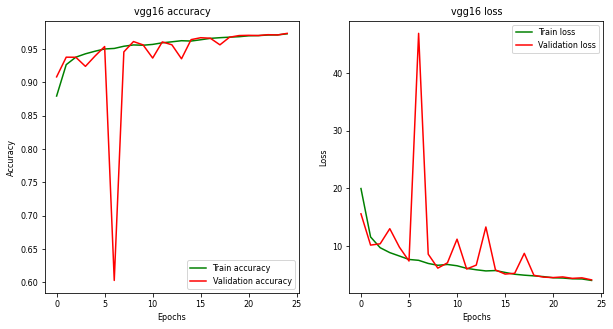

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], 'g')
plt.plot(history.history['val_acc'], 'r')
plt.legend(['Train accuracy', 'Validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('vgg16 accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.legend(['Train loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('vgg16 loss')

plt.savefig('../doc/vgg16.png')

In [9]:
y = []
for el in val_generator:
    y.append(el[1])
y = np.array(y)
y = y.argmax(axis=-1)
y.shape = (-1, 1)

In [6]:
pred = model.predict(val_generator, batch_size=64).argmax(axis=-1)
pred.shape = (-1, 1)

In [18]:
cr = classification_report(y, pred, target_names=['no data', 'deforestation', 'forestation', 'no change', 'water'])

In [10]:
cm = confusion_matrix(y, pred)

In [19]:
print(cr)
print()
print(cm)

               precision    recall  f1-score   support

      no data       0.99      0.99      0.99   8972223
deforestation       0.94      0.93      0.94   1232383
  forestation       0.86      0.91      0.88    266169
    no change       0.94      0.92      0.93   1755402
        water       0.99      0.99      0.99   1143167

     accuracy                           0.97  13369344
    macro avg       0.94      0.95      0.95  13369344
 weighted avg       0.97      0.97      0.97  13369344


[[8869845   25262   12922   52026   12168]
 [  37304 1151199       0   43880       0]
 [  10265       1  242809   13093       1]
 [  61007   50202   27303 1616889       1]
 [   6809       3      44      59 1136252]]


In [20]:
cm = cm / y.size

Text(34.0, 0.5, 'Actual')

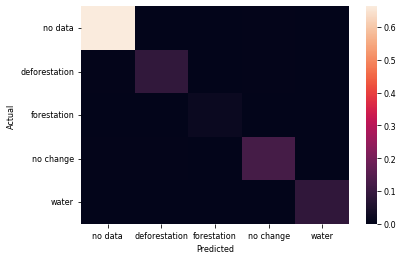

In [21]:
hm = heatmap(cm, xticklabels=['no data', 'deforestation', 'forestation', 'no change', 'water'], yticklabels=['no data', 'deforestation', 'forestation', 'no change', 'water'])
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')

In [22]:
cm_copy = cm.copy()
for i in range(5):
    cm_copy[i][i] = 0

Text(34.0, 0.5, 'Actual')

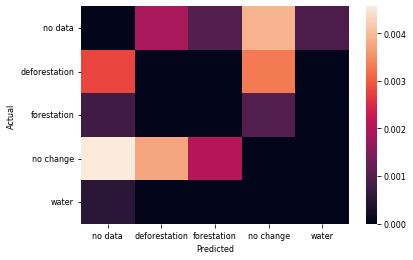

In [23]:
hm = heatmap(cm_copy, xticklabels=['no data', 'deforestation', 'forestation', 'no change', 'water'], yticklabels=['no data', 'deforestation', 'forestation', 'no change', 'water'])
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')